In [7]:
import pandas as pd
from utils import processor
from scipy import stats

In [2]:
# Get gwicids
gwic_filename = './data/missoula_valley_monitored_wells.csv'
metadf = pd.read_csv('./data/gwic_site_metadata.csv')
metadf = metadf[['gwicid', 'latitude', 'longitude']]
gwicids = metadf['gwicid'].values

<Axes: xlabel='time'>

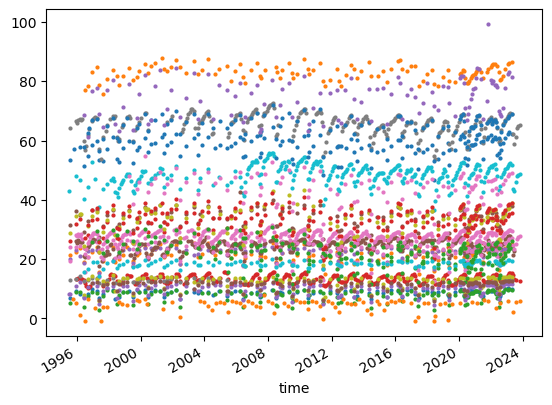

In [3]:
# Process gwic data
GWIC = processor.GWIC(gwicids)
gwic_data = GWIC.get_all_data(filename=gwic_filename, check_file=True)
gwic_data.plot(kind='line', style='o', legend=False, markersize=2)

<Axes: xlabel='time'>

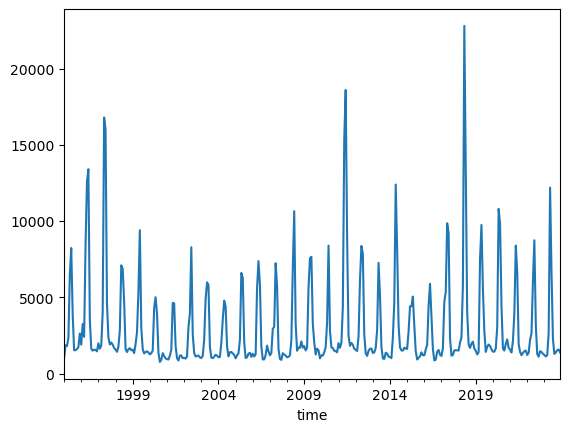

In [4]:
# Process USGS data
clk_fk_avb_mso = '12340500'
usgs_filename = './data/clark_fk_above_missoula_q.csv'
USGS = processor.USGS(clk_fk_avb_mso)
usgs_data = USGS.get_all_data(filename=usgs_filename, check_file=True)
usgs_data.plot(kind='line', legend=False)

<Axes: xlabel='time'>

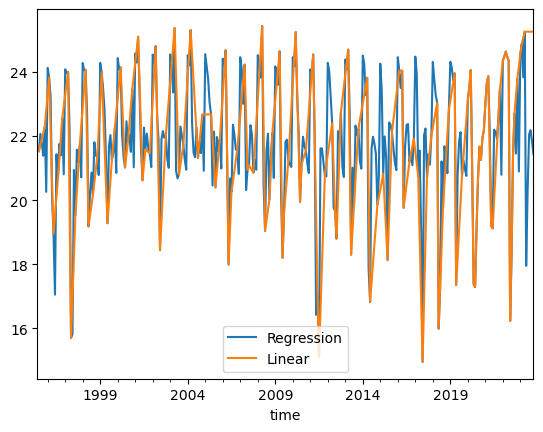

In [19]:
# Impute groundwater data
df = pd.concat([usgs_data, gwic_data], axis=1, join='inner')
Imputer = processor.Imputer(df)
df_reg = Imputer.q_and_doy_regression()
df_lin = Imputer.linear()
df_reg.to_csv('./data/missoula_valley_wells_imputed_qreg.csv')
df_lin.to_csv('./data/missoula_valley_wells_imputed_lin.csv')
df_reg.iloc[:, 2].plot(label='Regression', legend=True)
df_lin.iloc[:, 2].plot(label='Linear', legend=True)

In [43]:
# Standardize streamflow data
reg_method = 'linear'  # 'linear' or 'qreg'
if reg_method == 'linear':
    if 'df_lin' not in globals():
        df_lin = pd.read_csv('./data/missoula_valley_wells_imputed_lin.csv', index_col=0)
    df_norm = df_lin.copy()
elif reg_method == 'qreg':
    if 'df_reg' not in globals():
        df_reg = pd.read_csv('./data/missoula_valley_wells_imputed_qreg.csv', index_col=0)
    df_norm = df_reg.copy()
df_norm['Q'] = stats.zscore(df_norm['Q'])
df_norm.index = pd.to_datetime(df_norm.index)
# shift index to the beginning of the month
df_norm.index = df_norm.index.shift(-1, freq='MS')

In [47]:
# Standardize City pumping data and add to df_norm
pumping_data = pd.read_csv('./data/MSO_Mo_Pump.csv')
pumping_data.index = pd.to_datetime(pumping_data['yrmo'], format='%b %Y')
pumping_data['pumping_rate'] = stats.zscore(pumping_data['vol_Mg'])
df_norm = pd.concat([pumping_data['pumping_rate'], df_norm], axis=1, join='inner')